# Credit Card Fraud Detection

## Open-ended Lab



## Introduction

Imagine that you work for a financial institution and part of your job is to build a model that predicts if a credit card transaction is fraudulent or not. You can model the problem as a binary classification problem. A transaction belongs to the positive class (1) if it is a fraud, otherwise it belongs to the negative class (0).



In [5]:
# install the opendatasets package
!pip install opendatasets

import opendatasets as od

# download the dataset (this is a Kaggle dataset)
# during download you will be required to input your Kaggle username and password
od.download("https://www.kaggle.com/mlg-ulb/creditcardfraud")

Skipping, found downloaded files in ".\creditcardfraud" (use force=True to force download)


In [5]:
# Import the libraries we need to use in this lab
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

# Dataset Analysis

In [7]:
# read the input data
raw_data = pd.read_csv('creditcardfraud/creditcard.csv')
print("There are " + str(len(raw_data)) + " observations in the credit card fraud dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")

# display the first rows in the dataset
raw_data.head()

There are 284807 observations in the credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
n_replicas = 10

# inflate the original dataset
big_raw_data = pd.DataFrame(np.repeat(raw_data.values, n_replicas, axis=0), columns=raw_data.columns)

print("There are " + str(len(big_raw_data)) + " observations in the inflated credit card fraud dataset.")
print("There are " + str(len(big_raw_data.columns)) + " variables in the dataset.")

# display first rows in the new dataset
big_raw_data.head()

There are 2848070 observations in the inflated credit card fraud dataset.
There are 31 variables in the dataset.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
2,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
3,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
4,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0


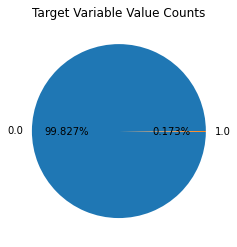

In [10]:
# get the set of distinct classes
labels = big_raw_data.Class.unique()

# get the count of each class
sizes = big_raw_data.Class.value_counts().values

# plot the class value counts
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.3f%%')
ax.set_title('Target Variable Value Counts')
plt.show()

As shown above, the Class variable has two values: 0 (the credit card transaction is legitimate) and 1 (the credit card transaction is fraudulent). Thus, you need to model a binary classification problem. Moreover, the dataset is highly unbalanced, the target variable classes are not represented equally. This case requires special attention when training or when evaluating the quality of a model. One way of handing this case at train time is to bias the model to pay more attention to the samples in the minority class. The models under the current study will be configured to take into account the class weights of the samples at train/fit time.

The credit card transactions have different amounts. plot a histogram that shows the distribution of these amounts? What is the range of these amounts (min/max)? print the percentiles of the amount values?

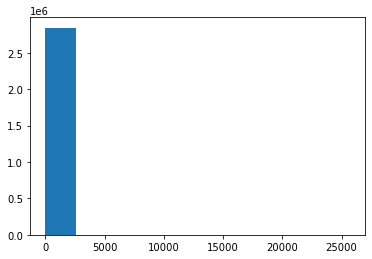

In [11]:
#Histogram
import matplotlib.pyplot as plt

x = np.random.normal(170, 10, 250)

plt.hist(big_raw_data['Amount'])
plt.show()

In [12]:
raw_data.min()
raw_data.max()


Time      172792.000000
V1             2.454930
V2            22.057729
V3             9.382558
V4            16.875344
V5            34.801666
V6            73.301626
V7           120.589494
V8            20.007208
V9            15.594995
V10           23.745136
V11           12.018913
V12            7.848392
V13            7.126883
V14           10.526766
V15            8.877742
V16           17.315112
V17            9.253526
V18            5.041069
V19            5.591971
V20           39.420904
V21           27.202839
V22           10.503090
V23           22.528412
V24            4.584549
V25            7.519589
V26            3.517346
V27           31.612198
V28           33.847808
Amount     25691.160000
Class          1.000000
dtype: float64

# Dataset Preprocessing
In this subsection you will prepare the data for training.

In [13]:
# data preprocessing such as scaling/normalization is typically useful for 
# linear models to accelerate the training convergence

# standardize features by removing the mean and scaling to unit variance
big_raw_data.iloc[:, 1:30] = StandardScaler().fit_transform(big_raw_data.iloc[:, 1:30])
data_matrix = big_raw_data.values

# X: feature matrix (for this analysis, we exclude the Time variable from the dataset)
X = data_matrix[:, 1:30]

# y: labels vector
y = data_matrix[:, 30]

# data normalization
X = normalize(X, norm="l1")

# print the shape of the features matrix and the labels vector
print('X.shape=', X.shape, 'y.shape=', y.shape)

X.shape= (2848070, 29) y.shape= (2848070,)


# Dataset Train/Test Split
Now that the dataset is ready for building the classification models, you need to first divide the pre-processed dataset into a subset to be used for training the model (the train set) and a subset to be used for evaluating the quality of the model (the test set).

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)       
print('X_train.shape=', X_train.shape, 'Y_train.shape=', y_train.shape)
print('X_test.shape=', X_test.shape, 'Y_test.shape=', y_test.shape)

X_train.shape= (1993649, 29) Y_train.shape= (1993649,)
X_test.shape= (854421, 29) Y_test.shape= (854421,)


# removing class imbalance

In [15]:
# compute the sample weights to be used as input to the train routine so that 
# it takes into account the class imbalance present in this dataset
w_train = compute_sample_weight('balanced', y_train)

# Build a classifier

In [16]:
#Packages related to general operating system & warnings
import os 
import warnings
warnings.filterwarnings('ignore')
#Packages related to data importing, manipulation, exploratory data #analysis, data understanding
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#Setting plot sizes and type of plot
plt.rc("font", size=14)
plt.rcParams['axes.grid'] = True
plt.figure(figsize=(6,3))
plt.gray()
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

<Figure size 432x216 with 0 Axes>

In [17]:
DT = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
DT.fit(X_train, y_train)
dt_yhat = DT.predict(X_test)

In [18]:
print('Accuracy score of the Decision Tree model is {}'.format(accuracy_score(y_test, dt_yhat)))

Accuracy score of the Decision Tree model is 0.9991936059624003


In [19]:
confusion_matrix(y_test, dt_yhat, labels = [0, 1])

array([[852873,     72],
       [   617,    859]], dtype=int64)

In [20]:
print('F1 score of the Decision Tree model is {}'.format(f1_score(y_test, dt_yhat)))

F1 score of the Decision Tree model is 0.7137515579559617


# Discuss your findings below

 
## I Choose decision tree algorithm, Because decision tree algorithm work well on structure data as compared to other algorithms and decision tree is faster beacuse of its automatic feature interacion.
## I also try XGbost but it was not working well on this scenario, the f1 score of XGbost is 1 so then I check the confuion matrix and I found that the positive false and negative false were zero so it show that it's not working well.
## KNN is also availble option but KNN does not work well on large data set because the cost of calculating is very high on large data set so it degrades the performance